In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from s2sphere import CellId
import matplotlib.pyplot as plt
from haversine import haversine, Unit
import random
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [22]:
# Load data
data_df = pd.read_csv('data/S2Cell_ID_level16.csv', usecols=[2], names=["S2_Cell_ID"], header=0)
vocab_df = pd.read_csv('data/uniqueS2s_level16.csv', names=["Token"])
data = list(map(int, data_df['S2_Cell_ID'].astype(str).str.strip()))
vocab_tokens = list(map(int, vocab_df['Token'].astype(str).str.strip()))
id_to_idx = {token: idx for idx, token in enumerate(vocab_tokens)}
indexed_data = [id_to_idx[cell_id] for cell_id in data if cell_id in id_to_idx]
data_tensor = torch.tensor(indexed_data, dtype=torch.long)
n = int(0.8 * len(data_tensor))
train_data = data_tensor[:n]
val_data = data_tensor[n:]
print("Data points:", len(indexed_data), "| Vocab size:", len(vocab_tokens))

Data points: 967089 | Vocab size: 103244


In [23]:
# Model definition
class SpatialGPT(nn.Module):
    def __init__(self, vocab_size, n_embd=128, n_layer=4, n_head=4, block_size=64):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, n_embd)
        self.pos_embedding = nn.Parameter(torch.zeros(1, block_size, n_embd))
        self.dropout = nn.Dropout(p=0.1)
        self.transformer = nn.TransformerDecoder(
            decoder_layer=nn.TransformerDecoderLayer(d_model=n_embd, nhead=n_head, batch_first=True),
            num_layers=n_layer
        )
        self.ln_f = nn.LayerNorm(n_embd)
        self.head = nn.Linear(n_embd, vocab_size)
        self.block_size = block_size

    def forward(self, x):
        B, T = x.size()
        tok_emb = self.token_embedding(x)
        pos_emb = self.pos_embedding[:, :T, :]
        x = self.dropout(tok_emb + pos_emb)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(T).to(x.device)
        x = self.transformer(x, x, tgt_mask=tgt_mask)
        x = self.ln_f(x)
        return self.head(x)

In [24]:
import time

def train_spatial_gpt_with_early_stopping(
    model, train_data, val_data, vocab_tokens,
    block_size=64, batch_size=32, steps=25001,
    eval_interval=1000, sample_interval=5000,
    checkpoint_path="spatial_gpt.pt", best_model_path="best_spatial_gpt.pt", patience=5
):
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=steps)
    loss_fn = nn.CrossEntropyLoss()

    train_losses, val_losses, times = [], [], []
    best_val_loss = float("inf")
    patience_counter = 0
    start_time = time.time()

    def get_batch(data):
        ix = torch.randint(len(data) - block_size, (batch_size,))
        x = torch.stack([data[i:i+block_size] for i in ix])
        y = torch.stack([data[i+1:i+block_size+1] for i in ix])
        return x.to(device), y.to(device)

    def evaluate(data):
        model.eval()
        xb, yb = get_batch(data)
        with torch.no_grad():
            logits = model(xb)
            loss = loss_fn(logits.view(-1, logits.size(-1)), yb.view(-1)).item()
        return loss

    def plot_losses():
        plt.figure(figsize=(10, 4))
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses, label="Val Loss")
        plt.xlabel("Evaluation Steps")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.legend()
        plt.grid(True)
        plt.show()

    def generate_sample():
        model.eval()
        start = torch.randint(0, len(train_data) - block_size, (1,))
        seed = train_data[start:start+block_size].unsqueeze(0).to(device)
        for _ in range(20):
            logits = model(seed[:, -block_size:])
            probs = torch.softmax(logits[:, -1, :], dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            seed = torch.cat([seed, next_token], dim=1)
        return seed[0].tolist()

    for step in range(steps):
        model.train()
        xb, yb = get_batch(train_data)
        logits = model(xb)
        loss = loss_fn(logits.view(-1, logits.size(-1)), yb.view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        if step % eval_interval == 0:
            train_loss = loss.item()
            val_loss = evaluate(val_data)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            times.append(time.time() - start_time)

            print(f"Step {step} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {times[-1]:.2f}s")
            plot_losses()

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(model.state_dict(), best_model_path)
                print(f"[Checkpoint] Best model saved -> {best_model_path}")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"[Early Stopping] No improvement in {patience} evals. Stopping early at step {step}.")
                    break

        if step % sample_interval == 0 and step > 0:
            sample_tokens = generate_sample()
            s2_ids = [vocab_tokens[tok] for tok in sample_tokens]
            print(f"\n[Sample @ step {step}]: {s2_ids[:10]}...")

        if step % 5000 == 0 and step > 0:
            torch.save(model.state_dict(), checkpoint_path)
            print(f"[Checkpoint] Model saved at step {step} -> {checkpoint_path}")

    torch.save(model.state_dict(), checkpoint_path)
    print(f"[Final] Model saved -> {checkpoint_path}")
    return train_losses, val_losses, times


In [25]:
# Utilities
def s2_to_latlng(s2_id):
    latlng = CellId(s2_id).to_lat_lng()
    return latlng.lat().degrees, latlng.lng().degrees

def haversine_distance(coord1, coord2):
    return haversine(coord1, coord2, unit=Unit.METERS)

def compute_distance_error(actual_coords, gen_coords):
    errors = []
    for a, g in zip(actual_coords, gen_coords):
        dist = haversine_distance(a, g)
        errors.append(dist)
    return np.mean(errors), errors

def plot_haversine_errors(actual_coords, gen_coords):
    _, step_errors = compute_distance_error(actual_coords, gen_coords)
    plt.figure(figsize=(8, 4))
    plt.plot(step_errors, marker='o')
    plt.title("Haversine Error per Step")
    plt.xlabel("Step")
    plt.ylabel("Distance Error (m)")
    plt.grid(True)
    plt.show()

In [26]:
# Sampling
def sample_next_token(logits, temperature=1.0, top_k=0, top_p=0.0):
    logits = logits / temperature
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
    if top_p > 0.0:
        sorted_indices_to_remove = cumulative_probs > top_p
        sorted_logits[sorted_indices_to_remove] = -float('Inf')
    if top_k > 0:
        sorted_logits[top_k:] = -float('Inf')
    probs = F.softmax(sorted_logits, dim=-1)
    next_token = torch.multinomial(probs, num_samples=1)
    return sorted_indices[next_token]

In [27]:
# Evaluation
def compare_actual_vs_generated(model, data, vocab_tokens, block_size=64, max_new_tokens=20, temperature=1.0, top_k=0, top_p=0.0, n_trials=3):
    model.eval()
    results = []
    for trial in range(n_trials):
        start = torch.randint(0, len(data) - block_size - max_new_tokens, (1,))
        seed = data[start:start+block_size].unsqueeze(0).to(device)
        actual = data[start+block_size:start+block_size+max_new_tokens]
        context = seed.clone()
        for _ in range(max_new_tokens):
            logits = model(context[:, -block_size:])
            next_token = sample_next_token(logits[0, -1], temperature, top_k, top_p)
            context = torch.cat([context, next_token.unsqueeze(0)], dim=1)
        generated = context[0, block_size:]
        actual_ids = [vocab_tokens[t.item()] for t in actual]
        gen_ids = [vocab_tokens[t.item()] for t in generated]
        actual_coords = [s2_to_latlng(s2) for s2 in actual_ids]
        gen_coords = [s2_to_latlng(s2) for s2 in gen_ids]
        avg_error, _ = compute_distance_error(actual_coords, gen_coords)
        results.append({
            "actual_coords": actual_coords,
            "generated_coords": gen_coords,
            "distance_error": avg_error
        })
        plt.figure(figsize=(8, 6))
        if actual_coords:
            lat_actual, lng_actual = zip(*actual_coords)
            plt.plot(lng_actual, lat_actual, marker='o', label='Actual', color='green')
        if gen_coords:
            lat_gen, lng_gen = zip(*gen_coords)
            plt.plot(lng_gen, lat_gen, marker='x', linestyle='--', label='Generated', color='blue')
        plt.title(f"Trial {trial+1}: Distance Error = {avg_error:.2f} m")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.legend()
        plt.grid(True)
        plt.show()
        plot_haversine_errors(actual_coords, gen_coords)
    return results

Step 0 | Train Loss: 11.7117 | Val Loss: 11.7215 | Time: 0.39s


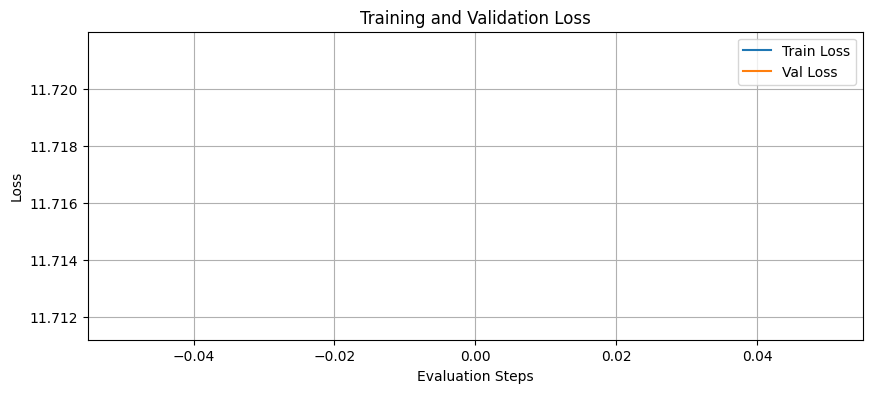

[Checkpoint] Best model saved -> best_spatial_gpt.pt
Step 1000 | Train Loss: 10.2658 | Val Loss: 10.8864 | Time: 77.27s


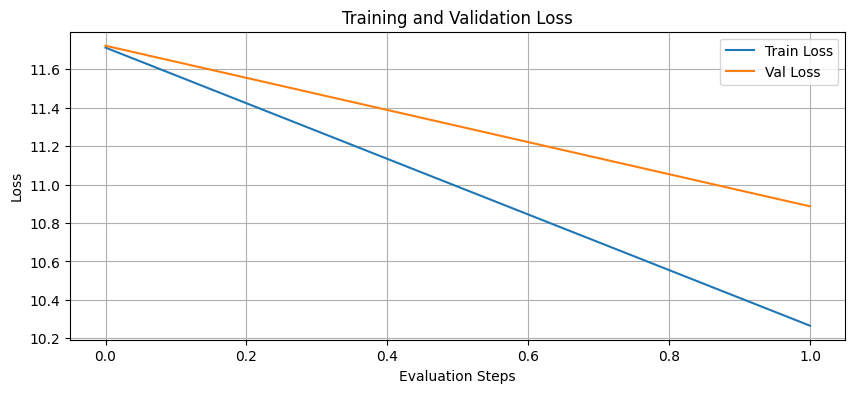

[Checkpoint] Best model saved -> best_spatial_gpt.pt
Step 2000 | Train Loss: 10.2274 | Val Loss: 11.1028 | Time: 152.65s


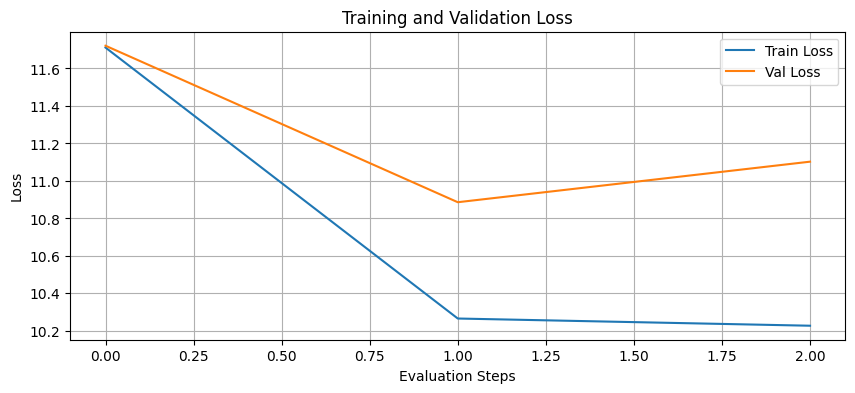

Step 3000 | Train Loss: 10.0455 | Val Loss: 11.0126 | Time: 227.26s


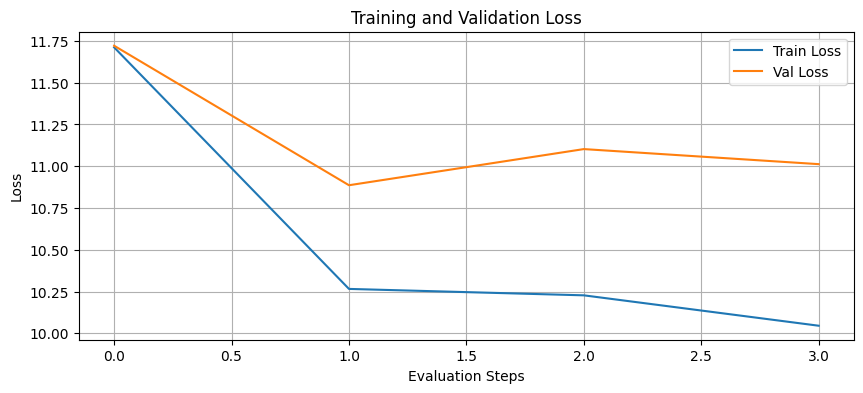

Step 4000 | Train Loss: 9.9975 | Val Loss: 11.0776 | Time: 301.85s


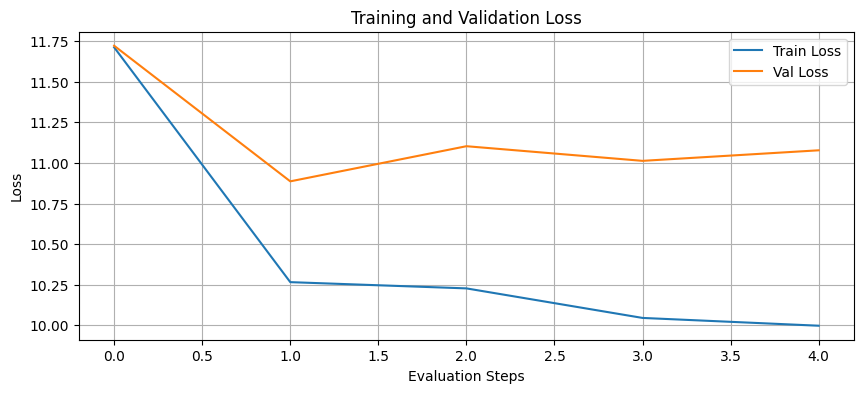

Step 5000 | Train Loss: 9.7815 | Val Loss: 10.9687 | Time: 376.45s


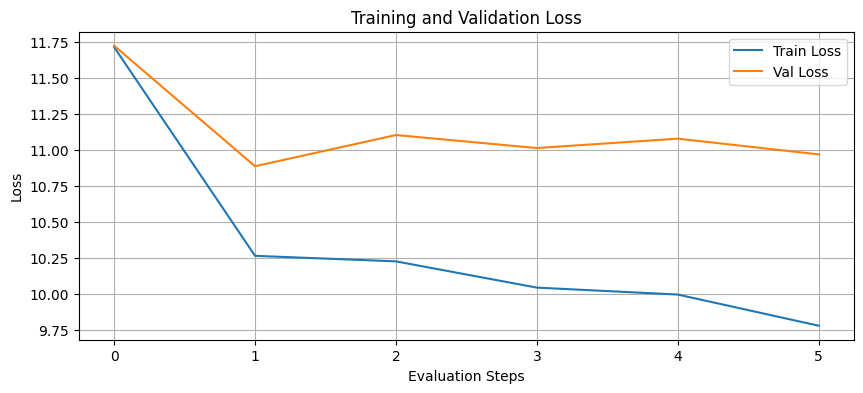


[Sample @ step 5000]: [12683695368521646080, 11915155471058599936, 11914945596407939072, 12007151601438425088, 12687453014470950912, 12687451472577691648, 12711412550198099968, 12006388545200586752, 12687451972941381632, 11831258982742228992]...
[Checkpoint] Model saved at step 5000 -> spatial_gpt.pt
Step 6000 | Train Loss: 9.5234 | Val Loss: 11.1511 | Time: 452.91s


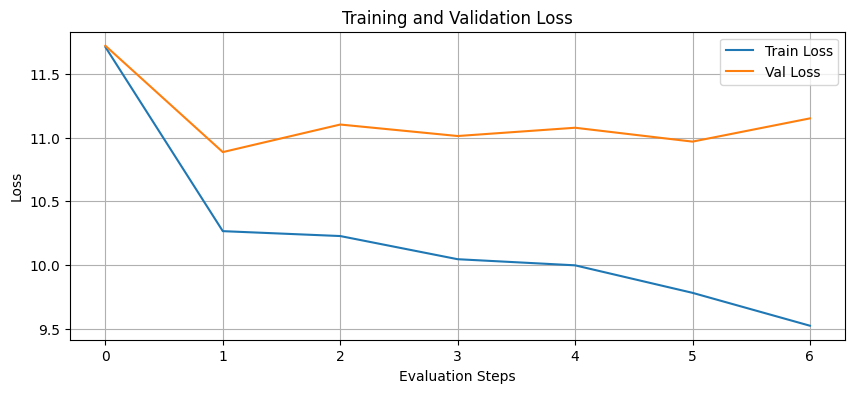

[Early Stopping] No improvement in 5 evals. Stopping early at step 6000.
[Final] Model saved -> spatial_gpt.pt


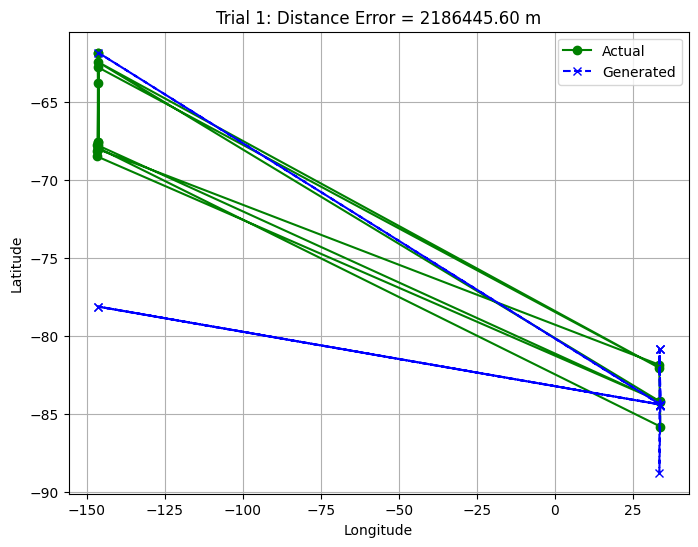

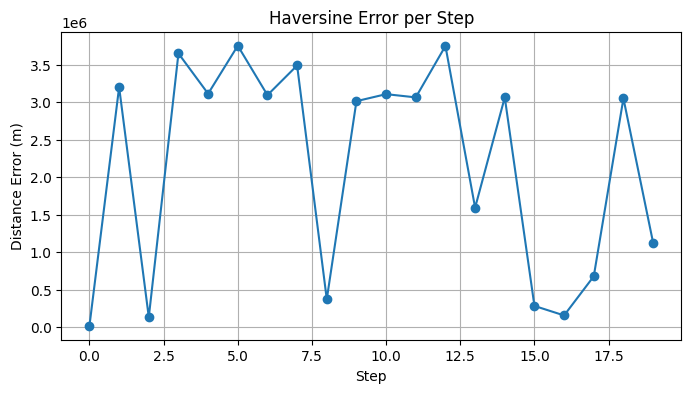

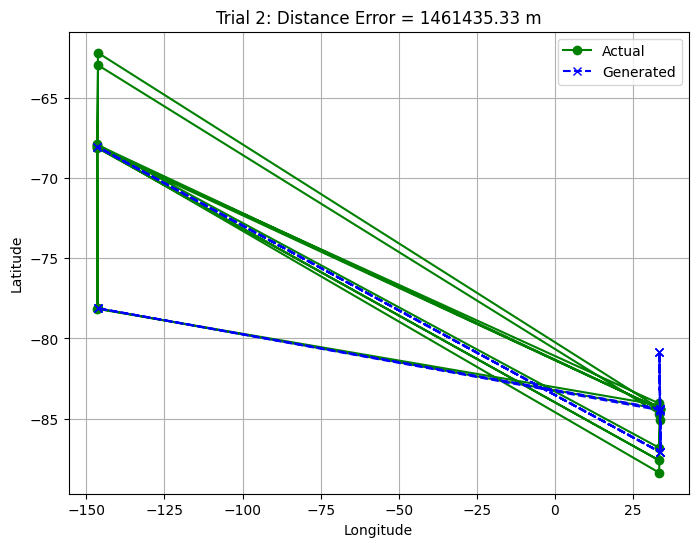

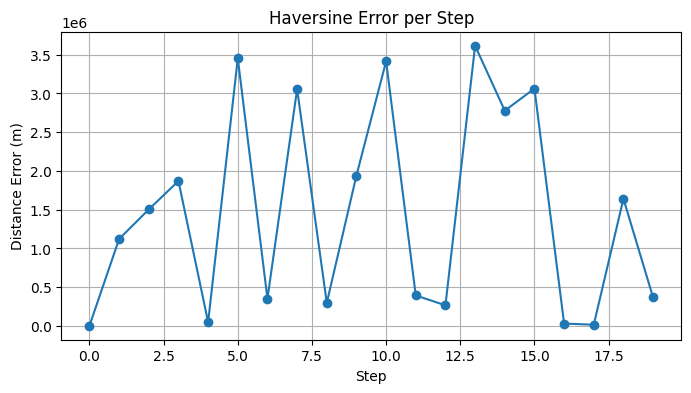

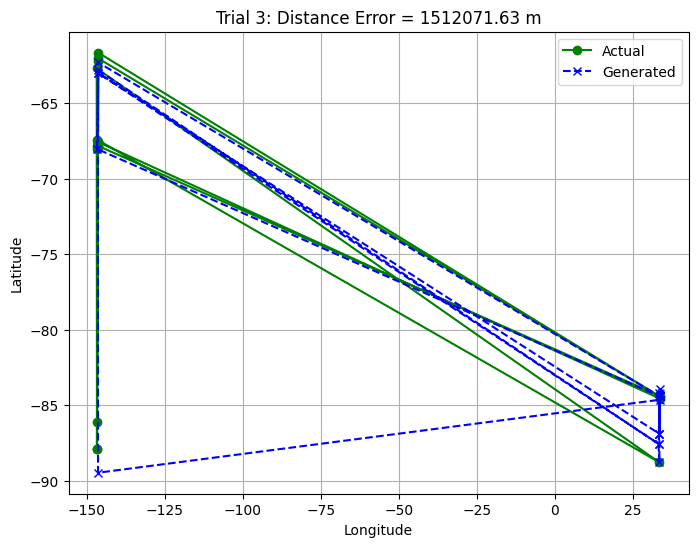

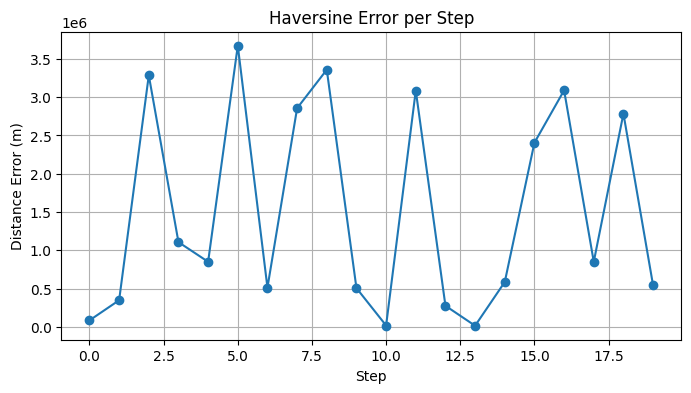

Average distance errors (m): [np.float64(2186445.6013661227), np.float64(1461435.331185313), np.float64(1512071.6257066457)]


In [28]:
# Train and evaluate
model = SpatialGPT(vocab_size=len(vocab_tokens), block_size=64).to(device)
train_losses, val_losses, times = train_spatial_gpt_with_early_stopping(
    model=model,
    train_data=train_data,
    val_data=val_data,
    vocab_tokens=vocab_tokens,
    steps=25001
)


results = compare_actual_vs_generated(
    model=model,
    data=val_data,
    vocab_tokens=vocab_tokens,
    block_size=64,
    max_new_tokens=20,
    temperature=1.0,
    top_k=20,
    top_p=0.9,
    n_trials=3
)

print("Average distance errors (m):", [r['distance_error'] for r in results])


In [31]:
def plot_single_comparison(model, data, vocab_tokens, block_size=64, max_new_tokens=20, temperature=1.0, top_k=0, top_p=0.0):
    """Plot actual vs generated path and return haversine error per step."""
    def sample_next_token(logits, temperature=1.0, top_k=0, top_p=0.0):
        logits = logits / temperature
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
        if top_p > 0.0:
            sorted_indices_to_remove = cumulative_probs > top_p
            sorted_logits[sorted_indices_to_remove] = -float('Inf')
        if top_k > 0:
            sorted_logits[top_k:] = -float('Inf')
        probs = F.softmax(sorted_logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        return sorted_indices[next_token]

    def haversine_distance(coord1, coord2):
        return haversine(coord1, coord2, unit=Unit.METERS)

    model.eval()
    start = torch.randint(0, len(data) - block_size - max_new_tokens, (1,))
    seed = data[start:start + block_size].unsqueeze(0).to(device)
    actual = data[start + block_size:start + block_size + max_new_tokens]

    with torch.no_grad():
        context = seed.clone()
        for _ in range(max_new_tokens):
            logits = model(context[:, -block_size:])
            next_token = sample_next_token(logits[0, -1], temperature, top_k, top_p)
            context = torch.cat([context, next_token.unsqueeze(0)], dim=1)
        generated = context[0, block_size:]

    actual_ids = [vocab_tokens[t.item()] for t in actual]
    gen_ids = [vocab_tokens[t.item()] for t in generated]
    actual_coords = [s2_to_latlng(s2) for s2 in actual_ids]
    gen_coords = [s2_to_latlng(s2) for s2 in gen_ids]

    # Plot spatial paths
    plt.figure(figsize=(8, 6))
    if actual_coords:
        lat_actual, lng_actual = zip(*actual_coords)
        plt.plot(lng_actual, lat_actual, marker='o', label='Actual', color='green')
    if gen_coords:
        lat_gen, lng_gen = zip(*gen_coords)
        plt.plot(lng_gen, lat_gen, marker='x', linestyle='--', label='Generated', color='blue')
    plt.legend()
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Actual vs Generated Spatial Path\nTemp={temperature}, Top-k={top_k}, Top-p={top_p}")
    plt.grid(True)
    plt.show()

    # Compute haversine distance per step
    step_errors = [
        haversine_distance(a, g) for a, g in zip(actual_coords, gen_coords)
    ]

    # Plot error per step
    plt.figure(figsize=(8, 4))
    plt.plot(step_errors, marker='o', color='orange')
    plt.title("Haversine Distance Error per Step")
    plt.xlabel("Step")
    plt.ylabel("Distance Error (meters)")
    plt.grid(True)
    plt.show()

    return {
        "actual_tokens": actual.tolist(),
        "generated_tokens": generated.tolist(),
        "actual_coords": actual_coords,
        "generated_coords": gen_coords,
        "step_errors_m": step_errors
    }


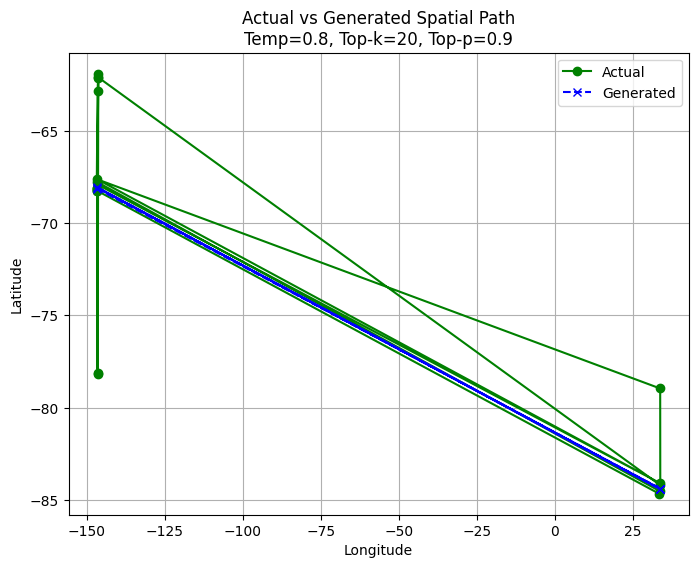

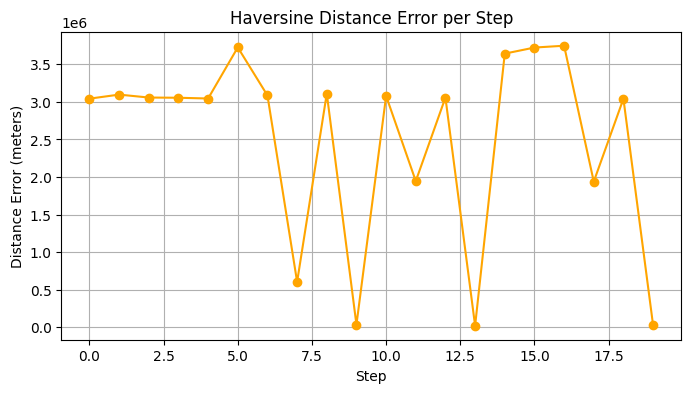

Step-by-step Haversine Errors (meters): [3042037.1389090708, 3095934.658123156, 3056810.4917759784, 3054139.2571048522, 3043976.2681353725, 3723909.715844652, 3084737.6563409586, 604185.4347329006, 3109529.377902714, 34967.70351300023, 3077937.445488872, 1945254.5260531264, 3056967.531650386, 21264.87334722156, 3641115.2387779783, 3721827.21646514, 3746225.4162720856, 1938455.2832073898, 3040940.097310856, 27821.214648326913]


In [32]:
result = plot_single_comparison(
    model=model,
    data=val_data,
    vocab_tokens=vocab_tokens,
    block_size=64,
    max_new_tokens=20,
    temperature=0.8,
    top_k=20,
    top_p=0.9
)

print("Step-by-step Haversine Errors (meters):", result["step_errors_m"])
